# Example: Integrated Center of Mass calculation

Prerequisites: 

 * A python3.7 or newer virtualenv with all requirements installed
  * LiberTEM 0.12.0 or newer
  * LiberTEM-iCoM 0.1.0 or newer
  * The dataset from https://zenodo.org/record/5113449

In [1]:
%matplotlib nbagg

In [2]:
import os

import numpy as np
import matplotlib.pyplot as plt
from libertem import api
import sparseconverter

from libertem_icom.udf.icom import ICoMUDF, iDPC

In [3]:
%precision 3

'%.3f'

This starts a local cluster that is accessible through ``ctx``. Starting several clusters in parallel is unproblematic because each cluster is rather lightweight and relies on the host file system for caching.

In [4]:
ctx = api.Context()

If you want to run this notebook, you may need to adjust the ``emd_path`` variable and ``hdf5path`` parameter here. This example uses a local HDF5 file as input dataset.

In [5]:
data_base_path = os.environ.get("TESTDATA_BASE_PATH", "/home/alex/Data/")
ds = ctx.load('auto', path=os.path.join(data_base_path, '20200518 165148/default.hdr'))

# we could also use the new type="auto" feature:
# here, the ds_path is set automatically to the largest dataset in the HDF5 file
# ds = ctx.load('auth', path=emd_path)

(scan_y, scan_x, detector_y, detector_x) = ds.shape

Now, we create a center of mass (COM) analysis.

The coordinate system transformation between scan and detector is taken from the info in https://zenodo.org/record/5113449

In [6]:
udf = ICoMUDF.with_params(cy=126, cx=123, flip_y=True, scan_rotation=88, r=40, regression=1)

We kick off the computation:

<IPython.core.display.Javascript object>


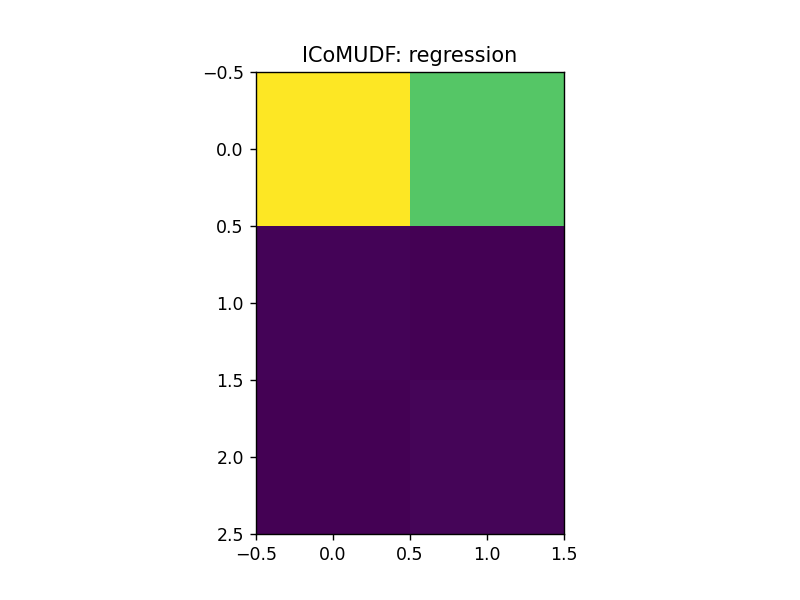

<IPython.core.display.Javascript object>


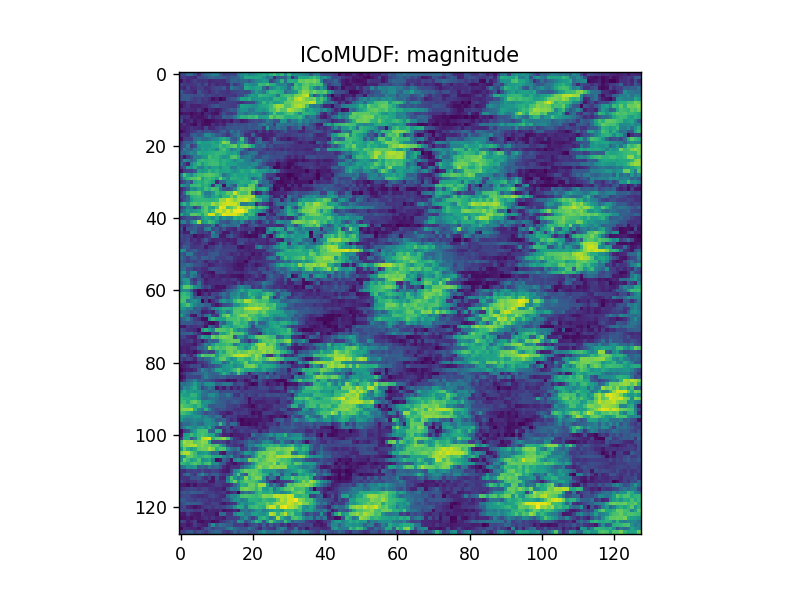

<IPython.core.display.Javascript object>


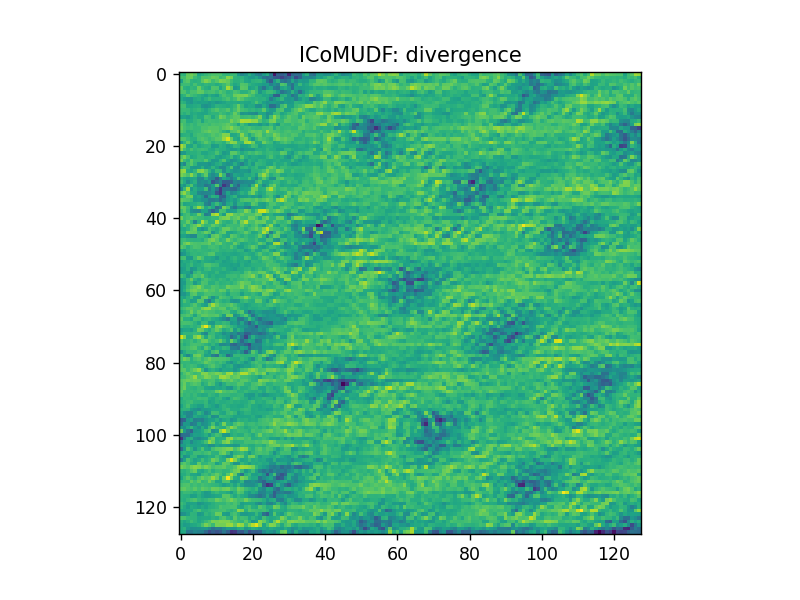

<IPython.core.display.Javascript object>


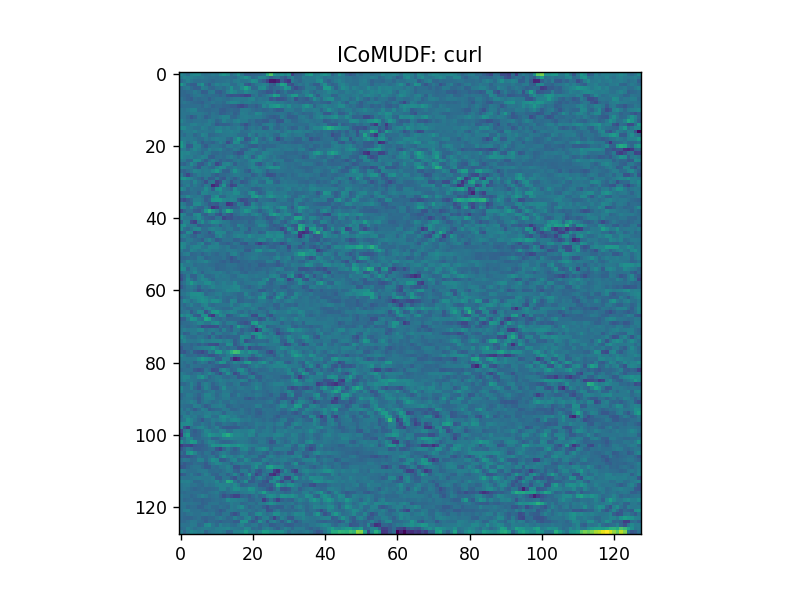

<IPython.core.display.Javascript object>


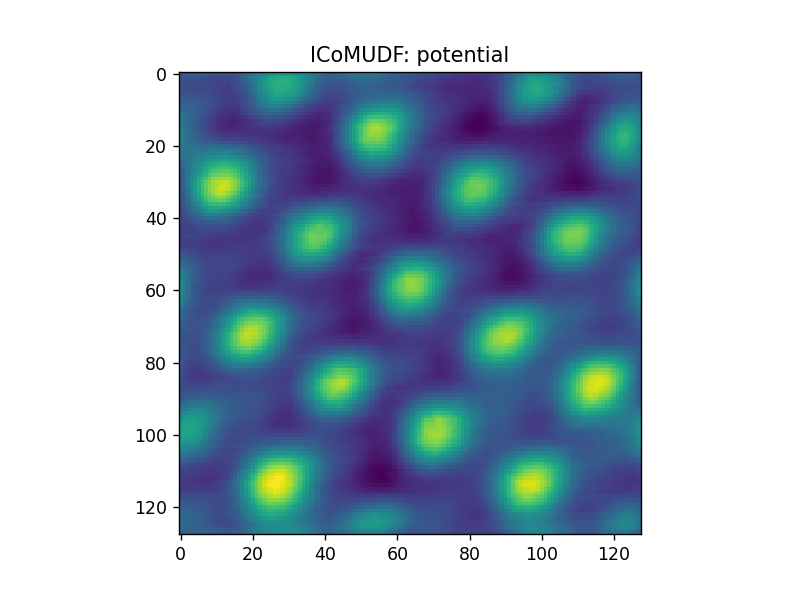

Partitions 0/8, Frames:   0%|          | 0/16384 [00:00<?, ?it/s]

CPU times: total: 469 ms
Wall time: 25.3 s


In [7]:
%time result = ctx.run_udf(dataset=ds, udf=udf, progress=True, plots=True)

## Use the `iDPC()` function

We can use `libertem_icom.udf.iDPC` on any shift vector field independent of the UDF:

In [8]:
# NBVAL_IGNORE_OUTPUT
# We can use the CPU or the GPU
xp = np
backend = sparseconverter.NUMPY
try:
    # CuPy can be a bit brittle, so we not only import, but also test it
    import cupy
    a = cupy.array((1, 2, 3))
    a.sum()
    xp = cupy
    backend = sparseconverter.CUPY
    print("Using CuPy")
except (ModuleNotFoundError, ImportError):
    cupy = None
    print("Using NumPy")

Using CuPy


In [9]:
# We extract the vector field from the UDF result in this case.
# Instead, the differential signal of a segmented detector could be used, for example.
y_centers = result['field'].data[..., 0]
x_centers = result['field'].data[..., 1]

In [10]:
idpc_result = iDPC(
    sparseconverter.for_backend(y_centers, backend),
    sparseconverter.for_backend(x_centers, backend),
    xp
)

<IPython.core.display.Javascript object>


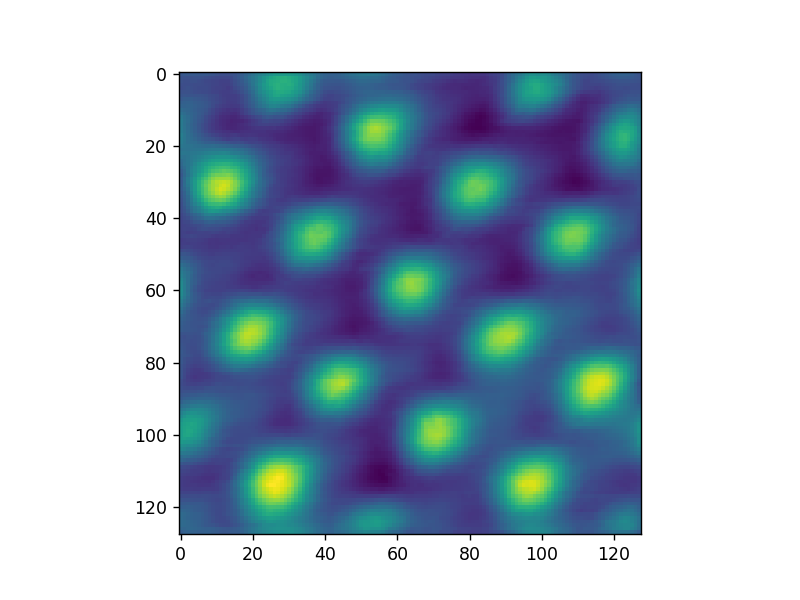

In [11]:
fig, axes = plt.subplots()
axes.imshow(sparseconverter.for_backend(idpc_result, sparseconverter.NUMPY))

In [12]:
%load_ext autoreload

In [13]:
%autoreload
potential = np.array((
    (0, 0, 0, 0, 0, 0, 0),
    (0, 0, 0, 0, 0, 0, 0),
    (0, 0, 0, 1, 0, 0, 0),
    (0, 0, 1, 1, 0, 0, 0),
    (0, 0, 1, 1, 0, 0, 0),
    (0, 0, 0, 0, 1, 0, 0),
    (0, 0, 0, 0, 0, 0, 0),
    (0, 0, 0, 0, 0, 0, 0),
)).astype(np.float64)
potential -= np.mean(potential)
y_field =  potential - np.roll(potential, 1, axis=0)
x_field = potential - np.roll(potential, 1, axis=1)

rec_potential = iDPC(y_field, x_field, np)

In [14]:
rec_potential

array([[-0.176, -0.191, -0.067,  0.013,  0.077,  0.028, -0.15 ],
       [-0.253, -0.17 , -0.156,  0.063,  0.184, -0.139, -0.151],
       [-0.312, -0.191, -0.271,  0.558,  0.363, -0.289, -0.152],
       [-0.317, -0.296,  0.125,  1.264,  0.455, -0.358, -0.251],
       [-0.274, -0.224,  0.753,  1.153,  0.158, -0.17 , -0.342],
       [-0.223, -0.24 ,  0.21 ,  0.424,  0.759,  0.147, -0.456],
       [-0.21 , -0.231, -0.161, -0.083,  0.42 ,  0.207, -0.236],
       [-0.226, -0.17 , -0.1  ,  0.075, -0.039, -0.047, -0.114]])

In [15]:
potential

array([[-0.107, -0.107, -0.107, -0.107, -0.107, -0.107, -0.107],
       [-0.107, -0.107, -0.107, -0.107, -0.107, -0.107, -0.107],
       [-0.107, -0.107, -0.107,  0.893, -0.107, -0.107, -0.107],
       [-0.107, -0.107,  0.893,  0.893, -0.107, -0.107, -0.107],
       [-0.107, -0.107,  0.893,  0.893, -0.107, -0.107, -0.107],
       [-0.107, -0.107, -0.107, -0.107,  0.893, -0.107, -0.107],
       [-0.107, -0.107, -0.107, -0.107, -0.107, -0.107, -0.107],
       [-0.107, -0.107, -0.107, -0.107, -0.107, -0.107, -0.107]])

<IPython.core.display.Javascript object>


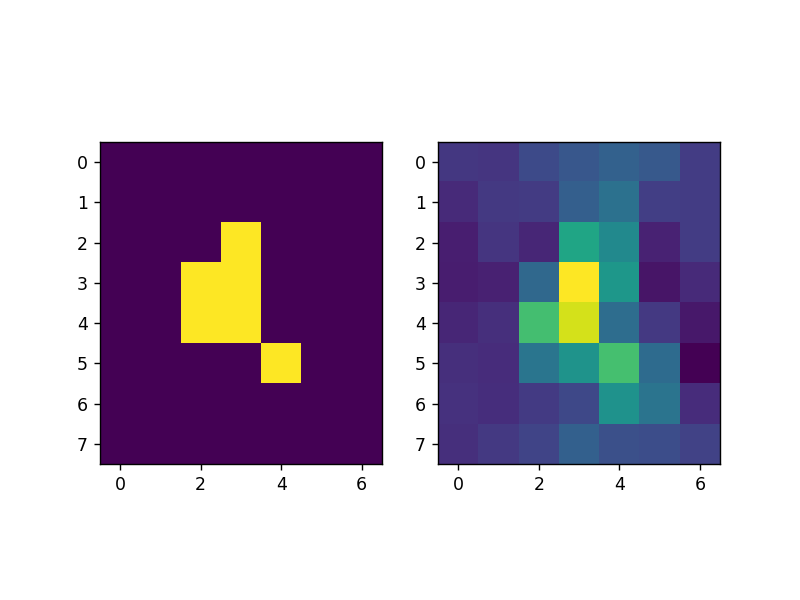

In [16]:
fig, axes = plt.subplots(1, 2)
axes[0].imshow(potential)
axes[1].imshow(rec_potential)

In [17]:
%autoreload
potential = np.random.random((256, 256))
potential -= np.mean(potential)
y_field =  potential - np.roll(potential, 1, axis=0)
x_field = potential - np.roll(potential, 1, axis=1)

rec_potential = iDPC(y_field, x_field, np)

In [18]:
tf = np.fft.fftshift(np.fft.fft2(rec_potential)/np.fft.fft2(potential))

<IPython.core.display.Javascript object>


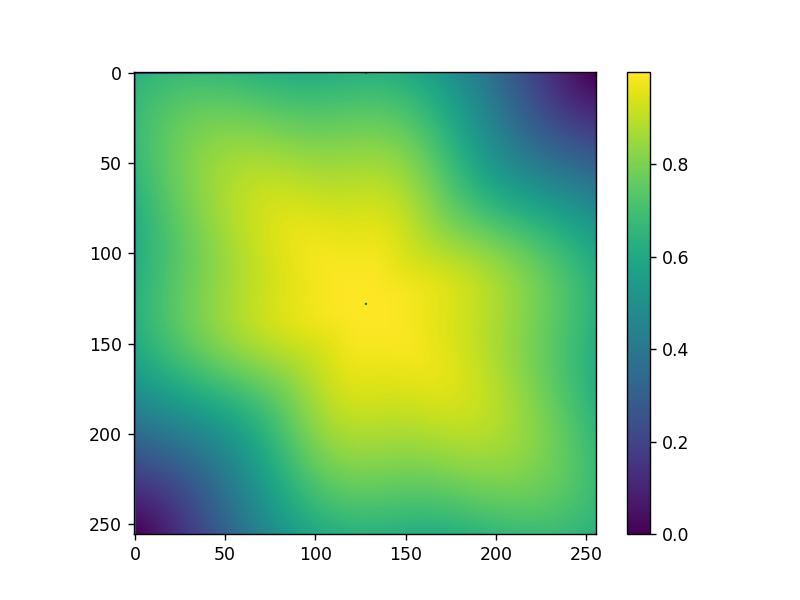

In [19]:
fig, axes = plt.subplots()
img = axes.imshow(np.abs(tf))
plt.colorbar(img, ax=axes)